## Huggingface's transformers library

Parts of this code based on https://huggingface.co/transformers/quickstart.html and https://github.com/strongio/keras-bert/blob/master/keras-bert.ipynb

Huggingface's `transformers` library is a very popular library that contains some of the latest complex architectures based on the Transformer. This library is used by an increasing number of developers and researchers to produce state-of-the-art results in multiple tasks. In this notebook, we will use what is arguably the most popular architecture, BERT, for the task of the classification of movie reviews (yes, this task again).

In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [2]:
#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession
#
#config = ConfigProto()
#config.gpu_options.allow_growth = True
#session = InteractiveSession(config=config)

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [4]:
# Uncomment this cell if you need to install transformers for google colab
!pip install transformers

If we are going to use the pre-trained weights provided by `transformers`, we need to make sure that we use the same tokenizer. The following code illustrates how to use the tokenizer bundled with the BERT model. The first thing we need to do is load the tokenizer from the pre-trained model.

In [4]:
from transformers import BertTokenizer, TFBertModel

In [5]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

The method `encode` will return the word indices. There are several special indices:

* 101 is used to encode the special token `[CLS]`. This token indicates the beginning of the string.
* 102 is used to encode the sentence separator `[SEP]`.

You will observe that the number of tokens does not correspond with the number of words. This is because BERT's tokeniser will split long words into shorter pieces of text. This is BERT's approach to address the problem of unknown words. By splitting long words into multiple tokens, we are less likely to find unknown words.

In [6]:
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokens = tokenizer.encode(text, add_special_tokens=False)
tokens

[101,
 2040,
 2001,
 3958,
 27227,
 1029,
 102,
 3958,
 27227,
 2001,
 1037,
 13997,
 11510,
 102]

In [7]:
tokenizer.decode(tokens)

'[CLS] who was jim henson? [SEP] jim henson was a puppeteer [SEP]'

The decoded version has converted all uppercase characters to lowercase. This is because we have used the pre-trained model "bert-case-uncased".

The process of tokenising can also be done through two steps: first find the words, then find the word indices. The code below shows that the word "puppeteer" has been split into two tokens: "puppet" and "##eer".

In [8]:
# Tokenize input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)
tokenized_text

['[CLS]',
 'who',
 'was',
 'jim',
 'henson',
 '?',
 '[SEP]',
 'jim',
 'henson',
 'was',
 'a',
 'puppet',
 '##eer',
 '[SEP]']

In [9]:
# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
indexed_tokens

[101,
 2040,
 2001,
 3958,
 27227,
 1029,
 102,
 3958,
 27227,
 2001,
 1037,
 13997,
 11510,
 102]

# IMDB data preparation
From https://github.com/strongio/keras-bert/blob/master/keras-bert.ipynb

We need to tokenise the IMDB data (we cannot use the word indices given by Keras). The following code downloads the IMDB data and loads it as a `pandas` data frame.

In [10]:
import os
import re
import pandas as pd
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)

  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))

  return train_df, test_df

In [11]:
train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,sentiment,polarity
0,I anticipated this movie to be decent and poss...,9,1
1,-=contains spoiler from both original and movi...,1,0
2,STAR RATING: ***** Saturday Night **** Friday ...,4,0
3,A fascinating look at the relationship of a si...,10,1
4,The Old Mill Pond is more of a tribute to the ...,10,1


We now load the text and the labels. We use the "polarity" column for the labels.

In [12]:
import numpy as np
# Create datasets (Only take up to max_seq_length words for memory)
max_seq_length = 500
train_text = train_df['sentence'].tolist()
train_text = [' '.join(t.split()[0:max_seq_length]) for t in train_text]
#train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = train_df['polarity'].tolist()

test_text = test_df['sentence'].tolist()
test_text = [' '.join(t.split()[0:max_seq_length]) for t in test_text]
#test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = test_df['polarity'].tolist()


In [13]:
train_text[:3]

["I anticipated this movie to be decent and possibly cliché, but I was completely wrong! Charlie Cox (I had never heard of him until now) played an incredibly good leading man; he was so earnest and romantic, me and my friend that saw the movie with me totally fell in love with him.<br /><br />Claire Danes, who I did like before (LOVED her in Romeo and Juliet), made me enjoy her even more. Her acting was fantastic, I couldn't even tell that she was American. The chemistry between her and Charlie Cox was extremely good, the casting was quite perfect.<br /><br />Robert DeNiro and Michelle Pfeiffer were equally well-casted; DeNiro as that gay pirate...priceless, priceless. I laughed so hard at that one scene where Septimus comes on the ship...oh my god, wow. Pfeiffer played a decent villain, I liked her as the snippy mother in Hairspray. But she had the right amount of melodrama and snide comments throughout the movie. <br /><br />Overall, it was funny (but not slap-stick at all!), romant

In [14]:
train_label[:3]

[1, 0, 0]

In [15]:
train_indices = [tokenizer.encode(t, add_special_tokens=True, max_length=500, padding='max_length', truncation=True) for t in train_text]

In [16]:
test_indices = [tokenizer.encode(t, add_special_tokens=True, max_length=500, padding='max_length', truncation=True) for t in test_text]

If executing the above two lines is too slow and your computer has multiple CPUs, you can use the following parallel version that uses Python's `multiprocessing` library instead. Uncomment and execute the following cells.

In [17]:
#from multiprocessing import Pool
#from functools import partial
#def text_to_indices(data, limit=500):
#    "Convert the text to indices and pad-truncate to the maximum number of words"
#    with Pool() as pool:
#        return pool.map(partial(tokenizer.encode,
#                                      add_special_tokens=True, max_length=limit, padding='max_length', truncation=True),
#                         data)

In [18]:
#text_to_indices(["this is sentence 1", "this is sentence 2"], limit=10)

In [19]:
#print("Obtaining indices of train set")
#train_indices = text_to_indices(train_text)
#print("Obtaining indices of test set")
#test_indices = text_to_indices(test_text)

# Results with BERT
Let's now design a simple architecture that uses BERT for binary classification. Our approach will not modify the BERT weights, hence we use the option `trainable=False`.

In [20]:
# Load pre-trained model (weights)
bert = TFBertModel.from_pretrained('bert-base-uncased', trainable=False)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D

Below is the code that implements the model. Given that the BERT layer returns multiple outputs, we must use Keras' [functional API](https://keras.io/guides/functional_api/) where we use functions to define each layer. Each function takes as a parameter the output of the previous layer in the sequence of the model. 

Look, in particular, at the line `last_hidden_states = bert(inputs)[0]`. This line is using our definition of BERT, to which we apply the inputs. The layer returns a tuple of values, and we use the first element only (element with index 0). This element contains the information that we want, which is the list of BERT embeddings of each token.

Then, the final model is defined by defining what are the inputs and the outputs. In the code below, this is done in the line `bert_model = Model(inputs, outputs)`.

In [22]:
# From https://huggingface.co/transformers/_modules/transformers/modeling_tf_bert.html#TFBertModel
#inputs = tf.constant(indexed_tokens)[None, :] # Batch  size 1
inputs = Input(shape=(500,), dtype=tf.int32)
last_hidden_states = bert(inputs)[0]  # The last hidden-state is the first element of the output tuple
average_pooling = GlobalAveragePooling1D()(last_hidden_states) # Average pooling of last hidden states as recommended
outputs = Dense(1, activation=tf.nn.sigmoid)(average_pooling)
bert_model = Model(inputs, outputs)
bert_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 500, 768), (None, 109482240 
_________________________________________________________________
global_average_pooling1d (Gl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 109,483,009
Trainable params: 769
Non-trainable params: 109,482,240
_________________________________________________________________


In [23]:
bert_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['acc'])

In [24]:
history = bert_model.fit(np.array(train_indices), np.array(train_label),
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/20
157/157 [==============================] - 559s 4s/step - loss: 0.6593 - acc: 0.6424 - val_loss: 0.6229 - val_acc: 0.6506
Epoch 2/20
157/157 [==============================] - 561s 4s/step - loss: 0.5984 - acc: 0.7525 - val_loss: 0.5681 - val_acc: 0.7428
Epoch 3/20
157/157 [==============================] - 473s 3s/step - loss: 0.5599 - acc: 0.7705 - val_loss: 0.5297 - val_acc: 0.7984
Epoch 4/20
157/157 [==============================] - 453s 3s/step - loss: 0.5331 - acc: 0.7849 - val_loss: 0.5038 - val_acc: 0.7960
Epoch 5/20
157/157 [==============================] - 453s 3s/step - loss: 0.5117 - acc: 0.7926 - val_loss: 0.4862 - val_acc: 0.7976
Epoch 6/20
157/157 [==============================] - 453s 3s/step - loss: 0.4956 - acc: 0.8002 - val_loss: 0.4700 - val_acc: 0.8068
Epoch 7/20
157/157 [==============================] - 453s 3s/step - loss: 0.4818 - acc: 0.8074 - val_loss: 0.4600 - val_acc: 0.8064
Epoch 8/20
157/157 [==============================] - 453s 3s/step - 

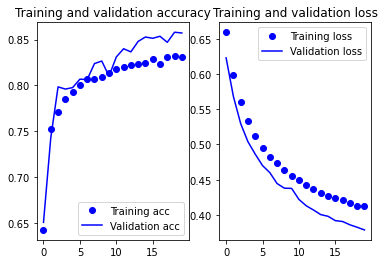

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Results with Average baseline
For comparison, below is a simpler architecture that uses a simple embedding layer instead of BERT, as we have seen in previous notebooks. The system will process exactly the same data.

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalAveragePooling1D

In [27]:
max_features = tokenizer.vocab_size
embeddings_size = 32
inputs = Input(shape=(500,), dtype=tf.int32)
embedding = Embedding(max_features, embeddings_size)(inputs)
avg = GlobalAveragePooling1D()(embedding)
outputs = Dense(1, activation=tf.nn.sigmoid)(avg)
avg_model = Model(inputs, outputs)
avg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 32)           976704    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 976,737
Trainable params: 976,737
Non-trainable params: 0
_________________________________________________________________


In [28]:
avg_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['acc'])

In [29]:
history = avg_model.fit(np.array(train_indices), np.array(train_label),
                    epochs=50,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/50
157/157 [==============================] - 2s 15ms/step - loss: 0.6864 - acc: 0.6499 - val_loss: 0.6747 - val_acc: 0.7464
Epoch 2/50
157/157 [==============================] - 2s 15ms/step - loss: 0.6543 - acc: 0.7570 - val_loss: 0.6290 - val_acc: 0.7780
Epoch 3/50
157/157 [==============================] - 2s 15ms/step - loss: 0.6008 - acc: 0.7768 - val_loss: 0.5736 - val_acc: 0.7922
Epoch 4/50
157/157 [==============================] - 2s 15ms/step - loss: 0.5441 - acc: 0.8096 - val_loss: 0.5190 - val_acc: 0.8218
Epoch 5/50
157/157 [==============================] - 2s 14ms/step - loss: 0.4923 - acc: 0.8357 - val_loss: 0.4736 - val_acc: 0.8372
Epoch 6/50
157/157 [==============================] - 2s 14ms/step - loss: 0.4474 - acc: 0.8553 - val_loss: 0.4348 - val_acc: 0.8526
Epoch 7/50
157/157 [==============================] - 2s 15ms/step - loss: 0.4093 - acc: 0.8714 - val_loss: 0.4040 - val_acc: 0.8622
Epoch 8/50
157/157 [==============================] - 2s 14ms/step - 

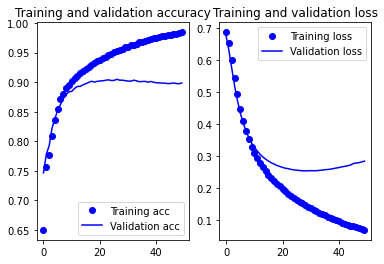

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The system overfits much more than with BERT, but accuracy of the validation data is higher (better) than with BERT. This shows that it makes sense always to try a simple architecture before trying more complex and advanced architectures.

# Results with LSTM baseline
An another baseline, this time using an LSTM layer.

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM

In [32]:
max_features = tokenizer.vocab_size
embeddings_size = 32
inputs = Input(shape=(500,), dtype=tf.int32)
embedding = Embedding(max_features, embeddings_size)(inputs)
lstm = LSTM(embeddings_size, dropout=0.2)(embedding)
outputs = Dense(1, activation=tf.nn.sigmoid)(lstm)
lstm_model = Model(inputs, outputs)
lstm_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 32)           976704    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 985,057
Trainable params: 985,057
Non-trainable params: 0
_________________________________________________________________


In [33]:
lstm_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['acc'])

In [34]:
history = lstm_model.fit(np.array(train_indices), np.array(train_label),
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/30
157/157 [==============================] - 5s 32ms/step - loss: 0.6932 - acc: 0.5040 - val_loss: 0.6932 - val_acc: 0.4986
Epoch 2/30
157/157 [==============================] - 4s 28ms/step - loss: 0.6918 - acc: 0.5191 - val_loss: 0.6925 - val_acc: 0.5036
Epoch 3/30
157/157 [==============================] - 5s 29ms/step - loss: 0.6763 - acc: 0.5443 - val_loss: 0.6734 - val_acc: 0.5350
Epoch 4/30
157/157 [==============================] - 4s 28ms/step - loss: 0.6349 - acc: 0.5624 - val_loss: 0.6866 - val_acc: 0.5342
Epoch 5/30
157/157 [==============================] - 5s 30ms/step - loss: 0.6215 - acc: 0.5750 - val_loss: 0.6921 - val_acc: 0.5368
Epoch 6/30
157/157 [==============================] - 5s 30ms/step - loss: 0.5973 - acc: 0.5756 - val_loss: 0.7091 - val_acc: 0.5324
Epoch 7/30
157/157 [==============================] - 4s 28ms/step - loss: 0.5889 - acc: 0.5811 - val_loss: 0.7283 - val_acc: 0.5470
Epoch 8/30
157/157 [==============================] - 4s 28ms/step - 

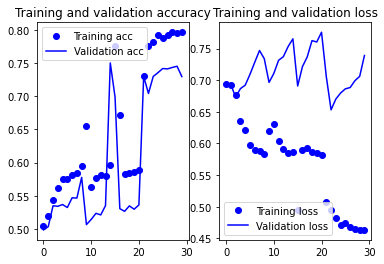

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()